<a href="https://colab.research.google.com/github/ShaunakNandi/Deep-Learning/blob/master/res18_densenetish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Project Summary*:

Spatially seperated conv2D on RESNET18 (24M params). Model draws inspiration from DenseNet to maintain the perspective of the input image itself at each and every concatenation

Removed dense layer

Image Aug implemented (8 parameters where batch_norm is implemented in model itself)

Implemented Cyclic LR

Max val acc: 53.56% (Epoch 105)

In [0]:
# https://keras.io/
!pip install -q keras
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.layers import Activation,AveragePooling2D,BatchNormalization,Concatenate,Conv2D,Flatten,GlobalAveragePooling2D,Lambda,MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model,Input
from keras.optimizers import Adam

from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from math import ceil
import os

import numpy as np

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


#Utility code I wrote to classify Val Images into their respective folders!!

In [0]:
# WHAT THIS CODE DOES:
# scans through validation images contained in a single folder
# collects batch of val images and copies them into respective folders
# folders are named according to the class name

# first the folders are created by scanning throught the txt file containing
#   folder names (class names).
#   folder names alone are copied to and saved into an excel sheet
# secondly, using the xlrd lib to read excel sheet cell values, the folder names
#   are scanned and val images with mathing folder (class) name is copied to resp
#   folder. Hence 50 images copied into each folder (tiny-imageNet)

import xlrd         #read excel sheet cell values
import os, fnmatch  #folder access
import shutil       #copyTo

img_path = '_PATH_TO_VAL_IMAGES_FOLDER_'
root_path = '_PATH_TO_VAL_FOLDER_'
created=[] #handle multiple files with same name (not really used though)

wb = xlrd.open_workbook(os.path.join(root_path, 'val_annotations.xlsx'))
sheet = wb.sheet_by_index(0)
def create_folders():
  for row in range(1, 10000+1):
    filename = sheet.cell_value(row,0)  #row,col
    if filename in created:
      continue
    else:
      os.mkdir(filename)
    created.append(filename)
    
def run():
  create_folders()
  i=0
  #for image in os.listdir(img_path):
  for img_index in range(10000):
    copy_from = os.path.join(img_path, 'val_%d.JPEG' %img_index)
    copy_to = sheet.cell_value(i,0)
    file1 = open("annot_maps2.txt","a") 
    file1.write(copy_from + ' : ' + copy_to + '\n')
    i+=1
    shutil.copy(copy_from, copy_to) #from, to
    if i%5 == 0: print('progress: %d' %((i+1)//100))
  file1.close() 

run()

#Run on system restarts (next two code blocks)

once is sufficient

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#unzip model
!unzip '/content/gdrive/My Drive/models/res22/res22.zip'

Archive:  /content/gdrive/My Drive/models/res22/res22.zip
  inflating: res22.h5                


In [0]:
#!unzip '/content/gdrive/My Drive/eip/tiny-imagenet-200.zip'
#!unzip '/content/gdrive/My Drive/eip/VAL_SELF.zip'   
#self made validation dataset (LABELLED)
!unzip '/content/gdrive/My Drive/tiny-imagenet-200_with_val_labels.zip'

Archive:  /content/gdrive/My Drive/tiny-imagenet-200_with_val_labels.zip
warning [/content/gdrive/My Drive/tiny-imagenet-200_with_val_labels.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/gdrive/My Drive/tiny-imagenet-200_with_val_labels.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
   creating: tiny-imagenet-200/test/
   creating: tiny-imagenet-200/test/images/
  inflating: tiny-imagenet-200/test/images/test_0.JPEG  
  inflating: tiny-imagenet-200/test/images/test_1.JPEG  
  inflating: tiny-imagenet-200/test/images/test_10.JPEG  
  inflating: tiny-imagenet-200/test/images/test_100.JPEG  
  inflating: tiny-imagenet-200/test/images/test_1000.JPEG  
  inflating: tiny-imagenet-200/test/images/test_1001.JPEG  
  inflating: tiny-imagenet-200/test/images/test_1002.JPEG  
  inflating: tiny-imagenet-200/test/images/test_1003.JPEG  
  inflating:

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

#ResNet18

In [0]:
#RESNET 18 ARCHITECTURE
#NOT residual yet.. trying to get entire code running
nb_classes=200 #trying with 10 classes first
img_height, img_width, channels = None, None, 3 #32,32,3#64,64,3

input = Input(shape=(img_height, img_width, channels,), name='input') 

#BLOCK1
Layer0a = Conv2D(64, (8,1), strides=(2,1), padding='same', name='conv1a', use_bias=False)(input)  #32,32,32
Layer0b = Conv2D(64, (1,8), strides=(1,2), padding='same', name='conv1b', use_bias=False)(Layer0a)  #32,32,32
Layer0 = BatchNormalization(name='norm1')(Layer0b)
Layer0 = Activation('relu')(Layer0)

#Layer0 = MaxPooling2D(pool_size=(3,3), strides=(1,1))(Layer0)
skip_connection = Layer0

#BLOCK 2a
# Layer 1 
Layer1a = Conv2D(64, (3,1), strides=(1,1), padding='same', name='conv2_1a', use_bias=False)(Layer0)  #32,32,32
Layer1b = Conv2D(64, (1,3), strides=(1,1), padding='same', name='conv2_1b', use_bias=False)(Layer1a)  #32,32,32
Layer1 = BatchNormalization(name='norm2_1')(Layer1b)
Layer1 = Activation('relu')(Layer1)
# Layer 2
Layer2a = Conv2D(64, (3,1), strides=(1,1), padding='same', name='conv2_2a', use_bias=False)(Layer1) #32,32,64
Layer2b = Conv2D(64, (1,3), strides=(1,1), padding='same', name='conv2_2b', use_bias=False)(Layer2a) #32,32,64
Layer2 = BatchNormalization(name='norm2_2')(Layer2b)
Layer2 = Activation('relu')(Layer2)

skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='valid', use_bias=False)(skip_connection)
skip_connection = BatchNormalization()(skip_connection)
skip_connection = Activation('relu')(skip_connection)
Layer2 = concatenate([skip_connection, Layer2])
skip_connection = Layer2

#BLOCK 2b
# Layer 3
Layer3a = Conv2D(64, (3,1), strides=(1,1), padding='same', name='conv2_3', use_bias=False)(Layer2) #32,32,128
Layer3b = Conv2D(64, (1,3), strides=(1,1), padding='same', name='conv2_3b', use_bias=False)(Layer3a) #32,32,128
Layer3 = BatchNormalization(name='norm2_3')(Layer3b)
Layer3 = Activation('relu')(Layer3)
# Layer 4
Layer4a = Conv2D(64, (3,1), strides=(1,1), padding='same', name='conv2_4a', use_bias=False)(Layer3)  #32,32,32
Layer4b = Conv2D(64, (1,3), strides=(1,1), padding='same', name='conv2_4b', use_bias=False)(Layer4a)  #32,32,32
Layer4 = BatchNormalization(name='norm2_4')(Layer4b)
Layer4 = Activation('relu')(Layer4)

skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='valid', use_bias=False)(skip_connection)
skip_connection = BatchNormalization()(skip_connection)
skip_connection = Activation('relu')(skip_connection)
Layer4 = concatenate([skip_connection, Layer4, Layer0])

#BLOCK 3a
# Layer 5
Layer5a = Conv2D(128, (3,1), strides=(2,1), padding='same', name='conv2_7a', use_bias=False)(Layer4)  #32,32,32
Layer5b = Conv2D(128, (1,3), strides=(1,2), padding='same', name='conv2_7b', use_bias=False)(Layer5a)
Layer5 = BatchNormalization(name='norm2_7')(Layer5b)
Layer5 = Activation('relu')(Layer5)
# Layer 6
Layer6a = Conv2D(128, (3,1), strides=(1,1), padding='same', name='conv2_8a', use_bias=False)(Layer5) #32,32,64
Layer6b = Conv2D(128, (1,3), strides=(1,1), padding='same', name='conv2_8b', use_bias=False)(Layer6a)
Layer6 = BatchNormalization(name='norm2_8')(Layer6b)
Layer6 = Activation('relu')(Layer6)

skip_connection = Layer6

#BLOCK 3b
# Layer 7
Layer7a = Conv2D(128, (3,1), strides=(1,1), padding='same', name='conv2_9a', use_bias=False)(Layer6) #32,32,128
Layer7b = Conv2D(128, (1,3), strides=(1,1), padding='same', name='conv2_9b', use_bias=False)(Layer7a)
Layer7 = BatchNormalization(name='norm2_9')(Layer7b)
Layer7 = Activation('relu')(Layer7)
# Layer 8
Layer8a = Conv2D(128, (3,1), strides=(1,1), padding='same', name='conv3_1a', use_bias=False)(Layer7)  #32,32,32
Layer8b = Conv2D(128, (1,3), strides=(1,1), padding='same', name='conv3_1b', use_bias=False)(Layer8a)
Layer8 = BatchNormalization(name='norm3_1')(Layer8b)
Layer8 = Activation('relu')(Layer8)

skip_connection = Conv2D(128, (1,1), strides=(1,1), padding='valid', use_bias=False)(skip_connection)
skip_connection = BatchNormalization()(skip_connection)
skip_connection = Activation('relu')(skip_connection)

forLayer8 = Layer0
forLayer8  = MaxPooling2D(pool_size=(2,2), strides=(2,2))(Layer0)
#forLayer8 = space_to_depth_x2(forLayer8)
print(forLayer8.shape)
Layer8 = concatenate([skip_connection, Layer8, forLayer8])
skip_connection = Layer8

#BLOCK 4a
# Layer 9
Layer9a = Conv2D(256, (3,1), strides=(2,1), padding='same', name='conv3_6a', use_bias=False)(Layer8) #32,32,128
Layer9b = Conv2D(256, (1,3), strides=(1,2), padding='same', name='conv3_6b', use_bias=False)(Layer9a)
Layer9 = BatchNormalization(name='norm3_6')(Layer9b)
Layer9 = Activation('relu')(Layer9)
# Layer 10
Layer10a = Conv2D(256, (3,1), strides=(1,1), padding='same', name='conv3_7a', use_bias=False)(Layer9)  #32,32,32
Layer10b = Conv2D(256, (1,3), strides=(1,1), padding='same', name='conv3_7b', use_bias=False)(Layer10a)
Layer10 = BatchNormalization(name='norm3_7')(Layer10b)
Layer10 = Activation('relu')(Layer10)

skip_connection = Layer10

#BLOCK 4b
# Layer 11
Layer11a = Conv2D(256, (3,1), strides=(1,1), padding='same', name='conv3_8a', use_bias=False)(Layer10) #32,32,64
Layer11b = Conv2D(256, (1,3), strides=(1,1), padding='same', name='conv3_8b', use_bias=False)(Layer11a)
Layer11 = BatchNormalization(name='norm3_8')(Layer11b)
Layer11 = Activation('relu')(Layer11)
# Layer 12
Layer12a = Conv2D(256, (3,1), strides=(1,1), padding='same', name='conv3_9a', use_bias=False)(Layer11) #32,32,128
Layer12b = Conv2D(256, (1,3), strides=(1,1), padding='same', name='conv3_9b', use_bias=False)(Layer12a)
Layer12 = BatchNormalization(name='norm3_9')(Layer12b)
Layer12 = Activation('relu')(Layer12)

forLayer12 = forLayer8
forLayer12 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(Layer8)
skip_connection = Conv2D(256, (1,1), strides=(1,1), padding='valid', use_bias=False)(skip_connection)
skip_connection = BatchNormalization()(skip_connection)
skip_connection = Activation('relu')(skip_connection)
Layer12 = concatenate([skip_connection, Layer12, forLayer12])


#BLOCK 5a
# Layer 13
Layer13a = Conv2D(512, (3,1), strides=(2,1), padding='same', name='conv4_9a', use_bias=False)(Layer12) #32,32,128
Layer13b = Conv2D(512, (1,3), strides=(1,2), padding='same', name='conv4_9b', use_bias=False)(Layer13a)
Layer13 = BatchNormalization(name='norm4_9')(Layer13b)
Layer13 = Activation('relu')(Layer13)
# Layer 14
Layer14a = Conv2D(512, (3,1), strides=(1,1), padding='same', name='conv4_10a', use_bias=False)(Layer13) #32,32,128
Layer14b = Conv2D(512, (1,3), strides=(1,1), padding='same', name='conv4_10b', use_bias=False)(Layer14a)
Layer14 = BatchNormalization(name='norm4_10')(Layer14b)
Layer14 = Activation('relu')(Layer14)

skip_connection = Layer14

#BLOCK 5b
# Layer 15
Layer15a = Conv2D(512, (3,1), strides=(1,1), padding='same', name='conv4_11a', use_bias=False)(Layer14) #32,32,128
Layer15b = Conv2D(512, (1,3), strides=(1,1), padding='same', name='conv4_11b', use_bias=False)(Layer15a)
Layer15 = BatchNormalization(name='norm4_11')(Layer15b)
Layer15 = Activation('relu')(Layer15)
# Layer 16
Layer16a = Conv2D(512, (3,1), strides=(1,1), padding='same', name='conv4_12a', use_bias=False)(Layer15) #32,32,128
Layer16b = Conv2D(512, (1,3), strides=(1,1), padding='same', name='conv4_12b', use_bias=False)(Layer16a)
Layer16 = BatchNormalization(name='norm4_12')(Layer16b)
Layer16 = Activation('relu')(Layer16)

forLayer16 = forLayer12
forLayer16 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(Layer12)
skip_connection = Conv2D(512, (1,1), strides=(1,1), padding='valid', use_bias=False)(skip_connection)
skip_connection = BatchNormalization()(skip_connection)
skip_connection = Activation('relu')(skip_connection)
Layer16 = concatenate([skip_connection, Layer16, forLayer16])

#BLOCK 6a
# Layer 15
Layer17a = Conv2D(1024, (3,1), strides=(1,1), padding='same', name='conv5_13a', use_bias=False)(Layer16) #32,32,128
Layer17b = Conv2D(1024, (1,3), strides=(1,1), padding='same', name='conv5_13b', use_bias=False)(Layer17a)
Layer17 = BatchNormalization(name='norm5_13')(Layer17b)
Layer17 = Activation('relu')(Layer17)

# Layer 16
Layer18a = Conv2D(1024, (3,1), strides=(1,1), padding='same', name='conv5_14a', use_bias=False)(Layer17) #32,32,128
Layer18b = Conv2D(1024, (1,3), strides=(1,1), padding='same', name='conv5_14b', use_bias=False)(Layer18a)
Layer18 = BatchNormalization(name='norm5_14')(Layer18b)
Layer18 = Activation('relu')(Layer18)


Layer21 = Conv2D(200, (1,1), strides=(1,1), padding='valid', use_bias=False)(Layer18)
print('layer21: ', Layer21.shape)
output = GlobalAveragePooling2D(data_format='channels_last', name='output')(Layer21)
output = Activation('softmax')(output)
print('output: ', output.shape)
print(output.shape)


Instructions for updating:
Colocations handled automatically by placer.
(?, ?, ?, 64)
layer21:  (?, ?, ?, 200)
output:  (?, 200)
(?, 200)


#Model Summary

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1a (Conv2D)                 (None, None, None, 6 1536        input[0][0]                      
__________________________________________________________________________________________________
conv1b (Conv2D)                 (None, None, None, 6 32768       conv1a[0][0]                     
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (None, None, None, 6 256         conv1b[0][0]                     
__________________________________________________________________________________________________
activation

#Optimizer : Adam

In [0]:
'''
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.lr
  return lr

optimizer = Adam(lr=0.01)
lr_metric = get_lr_metric(optimizer)
'''

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              # Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
              metrics = ['accuracy'])

#Run model (epoch 1 - 15)

In [0]:
'''
print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model loaded')
'''

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=0
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(32,32),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=100000 // 256,
        epochs=15,
        #initial_epoch=0,
        callbacks=[reduce_lr, checkpoints],
        validation_data=validation_generator,
        validation_steps=10000//32)

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model saved')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
390/390 [==============================] - 183s 470ms/step - loss: 4.7694 - acc: 0.0444 - val_loss: 7.1340 - val_acc: 0.0227

Epoch 00001: val_loss improved from inf to 7.13404, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 2/15
390/390 [==============================] - 171s 437ms/step - loss: 4.0884 - acc: 0.1149 - val_loss: 7.0365 - val_acc: 0.0465

Epoch 00002: val_loss improved from 7.13404 to 7.03651, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 3/15
390/390 [==============================] - 167s 429ms/step - loss: 3.6742 - acc: 0.1755 - val_loss: 5.9976 - val_acc: 0.0662

Epoch 00003: val_loss improved from 7.03651 to 5.99761, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 4/15
390/390 [==============================] - 169s 434ms/step - loss: 3.4087 - a

#Epoch 16 - 20

In [0]:
print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model loaded')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=0
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(16,16),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=100000 // 256,
        epochs=5,
        #initial_epoch=0,
        callbacks=[reduce_lr, checkpoints],
        validation_data=validation_generator,
        validation_steps=10000//32)

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model saved')

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/5
390/390 [==============================] - 152s 391ms/step - loss: 3.7835 - acc: 0.1810 - val_loss: 15.3649 - val_acc: 0.0184

Epoch 00001: val_loss improved from inf to 15.36488, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 2/5
390/390 [==============================] - 145s 372ms/step - loss: 3.2699 - acc: 0.2520 - val_loss: 14.9575 - val_acc: 0.0218

Epoch 00002: val_loss improved from 15.36488 to 14.95753, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 3/5
390/390 [==============================] - 143s 367ms/step - loss: 3.0604 - acc: 0.2857 - val_loss: 14.7667 - val_acc: 0.0320

Epoch 00003: val_loss improved from 14.95753 to 14.76666, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 4/5
390/390 [==============================] - 143s 368ms/step - loss: 2.8973 - acc: 0.3142 - val_

#Epoch 21 - 50

In [0]:
print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model loaded')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=0
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=100000 // 256,
        epochs=30,
        #initial_epoch=0,
        callbacks=[reduce_lr, checkpoints],
        validation_data=validation_generator,
        validation_steps=10000//32)

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model saved')

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/30
390/390 [==============================] - 458s 1s/step - loss: 2.7156 - acc: 0.3476 - val_loss: 2.7851 - val_acc: 0.3399

Epoch 00001: val_loss improved from inf to 2.78509, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 2/30
390/390 [==============================] - 448s 1s/step - loss: 2.2855 - acc: 0.4316 - val_loss: 2.6900 - val_acc: 0.3573

Epoch 00002: val_loss improved from 2.78509 to 2.68999, saving model to /content/gdrive/My Drive/models/res22/res22mod.h5
Epoch 3/30
390/390 [==============================] - 444s 1s/step - loss: 2.0822 - acc: 0.4746 - val_loss: 2.7361 - val_acc: 0.3647

Epoch 00003: val_loss did not improve from 2.68999
Epoch 4/30
390/390 [==============================] - 444s 1s/step - loss: 1.9131 - acc: 0.5092 - val_loss: 2.8453 - val_acc: 0.3504

Epoch 00004: val_loss did not improve from 2.68999
Epoc

#Epoch 51 - 55 : Intro Image Aug

In [0]:
print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod.h5')
print('model loaded')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod_aug.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=1./255,                      # 1. normalise pixel values to within 1. from 255.
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,            
        #samplewise_center=True,             # did not find images to implement upon
        #featurewise_std_normalization=True, # 2. ignored by keras since it is already implemented
        #samplewise_std_normalization=True,  # ignored again
        zoom_range=0.2,                      # 3. 20% random zoom
        horizontal_flip=True,                # 4. easily double no. of images by flipping across Y axis
        rotation_range=10,                   # 5. random rotate by 10 deg
        width_shift_range=0.2,               # 6. remove 20% of img along X axis (possibly remove ROI)
        height_shift_range=0.2               # 7. remove 20% of img along Y axis (possibly remove ROI)
        #fill_mode='nearest'                 # 8. fill_mode introduced later (forgot about it early on)
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=100000 // 256,
        epochs=5,
        #initial_epoch=0,
        callbacks=[reduce_lr, checkpoints],
        validation_data=validation_generator,
        validation_steps=10000//32)

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod_aug.h5')
print('model saved')

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/5
390/390 [==============================] - 467s 1s/step - loss: 2.7722 - acc: 0.3812 - val_loss: 2.9848 - val_acc: 0.3375

Epoch 00001: val_loss improved from inf to 2.98481, saving model to /content/gdrive/My Drive/models/res22/res22mod_aug.h5
Epoch 2/5
390/390 [==============================] - 455s 1s/step - loss: 2.1994 - acc: 0.4543 - val_loss: 2.7114 - val_acc: 0.3763

Epoch 00002: val_loss improved from 2.98481 to 2.71145, saving model to /content/gdrive/My Drive/models/res22/res22mod_aug.h5
Epoch 3/5
390/390 [==============================] - 455s 1s/step - loss: 2.0652 - acc: 0.4793 - val_loss: 2.6585 - val_acc: 0.3910

Epoch 00003: val_loss improved from 2.71145 to 2.65847, saving model to /content/gdrive/My Drive/models/res22/res22mod_aug.h5
Epoch 4/5
390/390 [==============================] - 455s 1s/step - loss: 1.9787 - acc: 0.4983 - val_loss: 2.

#Epoch 56 - 75

In [0]:
print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod_aug.h5')
print('model loaded')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod_aug.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=100000 // 256,
        epochs=20,
        #initial_epoch=0,
        callbacks=[reduce_lr, checkpoints],
        validation_data=validation_generator,
        validation_steps=10000//32)

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod_aug.h5')
print('model saved')

loading model
Instructions for updating:
Use tf.cast instead.
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/20
390/390 [==============================] - 507s 1s/step - loss: 1.9058 - acc: 0.5142 - val_loss: 2.8226 - val_acc: 0.3850

Epoch 00001: val_loss improved from inf to 2.82262, saving model to /content/gdrive/My Drive/models/res22/res22mod_aug.h5
Epoch 2/20
390/390 [==============================] - 494s 1s/step - loss: 1.8548 - acc: 0.5243 - val_loss: 2.6206 - val_acc: 0.4008

Epoch 00002: val_loss improved from 2.82262 to 2.62061, saving model to /content/gdrive/My Drive/models/res22/res22mod_aug.h5
Epoch 3/20
390/390 [==============================] - 487s 1s/step - loss: 1.7950 - acc: 0.5368 - val_loss: 2.7184 - val_acc: 0.3935

Epoch 00003: val_loss did not improve from 2.62061
Epoch 4/20
390/390 [==============================] - 486s 1s/step - loss: 1.7493 - acc: 0.5448 - val_loss: 2.5150 - val_acc: 0.4142


# Epoch 76 - 95 : Intro CyclicLR

### Clearly visible that the local minima is changing to a different saddle point

### Quicker convergence noticed as promised by the paper

#Git clone

In [0]:
print('cloning repo...')
!git clone https://github.com/bckenstler/CLR.git
print('clone complete')

cloning repo...
Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 1.48 MiB/s, done.
Resolving deltas: 100% (86/86), done.
clone complete


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod_aug.h5')
print('model loaded')

'''
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
'''

from CLR import clr_callback
clr = clr_callback.CyclicLR(mode='triangular', step_size=1950,
                     base_lr=1e-4, max_lr=0.1)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod_augCLR.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=100000 // 256,
        epochs=20,
        #initial_epoch=0,
        callbacks=[clr, checkpoints],
        validation_data=validation_generator,
        validation_steps=10000//32)

plt.plot(clr.history['val_loss'], clr.history['lr'])

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod_augCLR.h5')
print('model saved')

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/20
390/390 [==============================] - 507s 1s/step - loss: 2.4218 - acc: 0.4118 - val_loss: 11.2192 - val_acc: 0.0349

Epoch 00001: val_loss improved from inf to 11.21925, saving model to /content/gdrive/My Drive/models/res22/res22mod_augCLR.h5
Epoch 2/20
390/390 [==============================] - 495s 1s/step - loss: 2.8891 - acc: 0.3219 - val_loss: 12.9071 - val_acc: 0.0193

Epoch 00002: val_loss did not improve from 11.21925
Epoch 3/20
390/390 [==============================] - 492s 1s/step - loss: 2.9303 - acc: 0.3183 - val_loss: 7.6154 - val_acc: 0.0796

Epoch 00003: val_loss improved from 11.21925 to 7.61545, saving model to /content/gdrive/My Drive/models/res22/res22mod_augCLR.h5
Epoch 4/20
390/390 [==============================] - 491s 1s/step - loss: 2.9828 - acc: 0.3069 - val_loss: 9.6192 - val_acc: 0.0547

Epoch 00004: val_loss did not improv

KeyError: ignored

#Epoch 95 - 105 : Refining CLR : finding lr_base and lr_max

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/40
390/390 [==============================] - 484s 1s/step - loss: 1.5825 - acc: 0.5893 - val_loss: 2.4623 - val_acc: 0.4396

Epoch 00001: val_loss improved from inf to 2.46226, saving model to /content/gdrive/My Drive/models/res22/res22mod_augCLR_.h5
Epoch 2/40
390/390 [==============================] - 481s 1s/step - loss: 1.8590 - acc: 0.5274 - val_loss: 2.9708 - val_acc: 0.3653

Epoch 00002: val_loss did not improve from 2.46226
Epoch 3/40
390/390 [==============================] - 476s 1s/step - loss: 2.1353 - acc: 0.4720 - val_loss: 4.0243 - val_acc: 0.2468

Epoch 00003: val_loss did not improve from 2.46226
Epoch 4/40
390/390 [==============================] - 476s 1s/step - loss: 2.3558 - acc: 0.4285 - val_loss: 4.1370 - val_acc: 0.2030

Epoch 00004: val_loss did not improve from 2.46226
Epoch 5/40
390/390 [==============================] - 475s 1s/step 

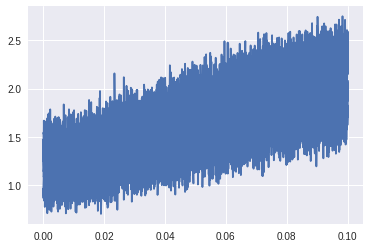

model saved


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod_augCLR.h5')
print('model loaded')

'''
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
'''
from CLR import clr_callback
clr = clr_callback.CyclicLR(mode='triangular', step_size=1560,
                     base_lr=1e-4, max_lr=0.1)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod_augCLR_.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model_history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100000 // 256,
                    epochs=40,
                    #initial_epoch=0,
                    callbacks=[clr, checkpoints],
                    validation_data=validation_generator,
                    validation_steps=10000//32)

hist = clr.history # keys: acc, batch, iterations, loss(val or train??), lr, size(train batch_size)
lr = hist['lr']
val_loss = hist['loss']
Iter = hist['iterations']
plt.plot(lr, val_loss)
#plt.plot(Iter, val_loss)
plt.show()

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod_augCLR_.h5')
print('model saved')

In [0]:
from google.colab import files
plt.savefig('Loss_vs_LR.PNG')
files.download('Loss_vs_LR.PNG')

<Figure size 432x288 with 0 Axes>

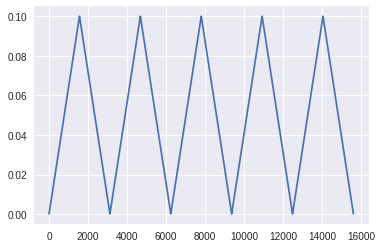

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(Iter, lr)
plt.show(Iter, lr)
from google.colab import files
plt.savefig('Iter_vs_LR.PNG')
files.download('Iter_vs_LR.PNG')


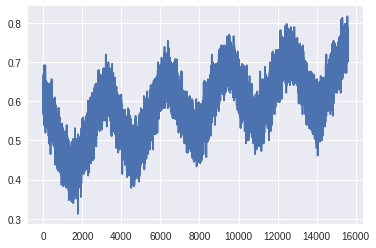

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(Iter, hist['acc'])
plt.show(Iter, hist['acc'])
from google.colab import files
plt.savefig('Acc_vs_Iter.PNG')
files.download('Acc_vs_Iter.PNG')

#Epoch 106 - 125 : fill_mode

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/20
390/390 [==============================] - 505s 1s/step - loss: 0.9021 - acc: 0.7486 - val_loss: 2.3355 - val_acc: 0.5061

Epoch 00001: val_loss improved from inf to 2.33554, saving model to /content/gdrive/My Drive/models/res22/res22mod_augCLR_fill_mode.h5
Epoch 2/20
390/390 [==============================] - 502s 1s/step - loss: 1.0477 - acc: 0.7109 - val_loss: 2.6218 - val_acc: 0.4729

Epoch 00002: val_loss did not improve from 2.33554
Epoch 3/20
390/390 [==============================] - 496s 1s/step - loss: 1.2478 - acc: 0.6622 - val_loss: 2.8573 - val_acc: 0.4291

Epoch 00003: val_loss did not improve from 2.33554
Epoch 4/20
390/390 [==============================] - 495s 1s/step - loss: 1.4541 - acc: 0.6133 - val_loss: 3.3412 - val_acc: 0.3634

Epoch 00004: val_loss did not improve from 2.33554
Epoch 5/20
390/390 [==============================] - 496s

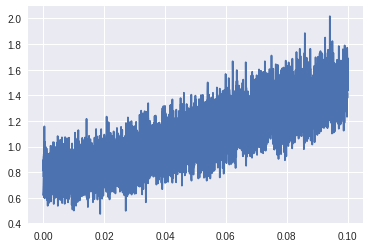

model saved


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod_augCLR_.h5')
print('model loaded')

'''
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
'''
from CLR import clr_callback
clr = clr_callback.CyclicLR(mode='triangular', step_size=1560,
                     base_lr=1e-4, max_lr=0.1)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22mod_augCLR_fill_mode.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model_history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100000 // 256,
                    epochs=20,
                    #initial_epoch=0,
                    callbacks=[clr, checkpoints],
                    validation_data=validation_generator,
                    validation_steps=10000//32)

hist = clr.history # keys: acc, batch, iterations, loss(val or train??), lr, size(train batch_size)
lr = hist['lr']
val_loss = hist['loss']
Iter = hist['iterations']
plt.plot(lr, val_loss)
#plt.plot(Iter, val_loss)
plt.show()

model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22mod_augCLR_fill_mode.h5')
print('model saved')

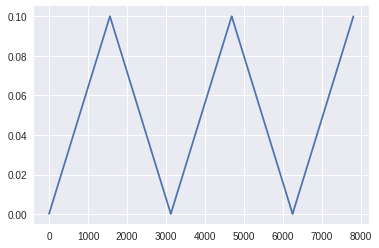

In [0]:
plt.plot(clr.history['iterations'], clr.history['lr'])

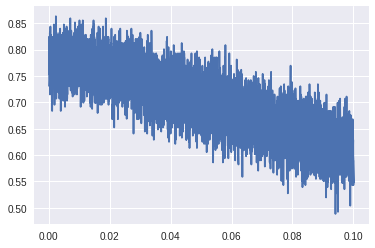

In [0]:
plt.plot(clr.history['lr'], clr.history['acc'])

#Epoch 126 - 160 : Pushing the accuracies to max limit/ saturation

loading model
model loaded
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/40
390/390 [==============================] - 491s 1s/step - loss: 0.9411 - acc: 0.7360 - val_loss: 2.4382 - val_acc: 0.5154

Epoch 00001: val_loss improved from inf to 2.43816, saving model to /content/gdrive/My Drive/models/res22/res22_final.h5
Epoch 2/40
390/390 [==============================] - 488s 1s/step - loss: 0.8717 - acc: 0.7540 - val_loss: 2.8414 - val_acc: 0.4694

Epoch 00002: val_loss did not improve from 2.43816
Epoch 3/40
390/390 [==============================] - 484s 1s/step - loss: 1.0106 - acc: 0.7182 - val_loss: 3.1440 - val_acc: 0.4224

Epoch 00003: val_loss did not improve from 2.43816
Epoch 4/40
390/390 [==============================] - 484s 1s/step - loss: 1.2037 - acc: 0.6707 - val_loss: 3.1740 - val_acc: 0.4076

Epoch 00004: val_loss did not improve from 2.43816
Epoch 5/40
390/390 [==============================] - 481s 1s/step - los

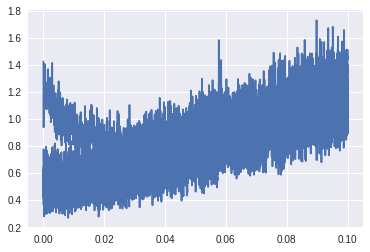

model saved


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

print('loading model')
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/models/res22/res22mod_augCLR_fill_mode.h5')
print('model loaded')

'''
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00099)
'''
from CLR import clr_callback
clr = clr_callback.CyclicLR(mode='triangular', step_size=1560,
                     base_lr=1e-4, max_lr=0.1)
checkpoints = ModelCheckpoint(filepath='/content/gdrive/My Drive/models/res22/res22_final.h5', 
                               verbose=1,
                               save_weights_only=False,
                               save_best_only=True)

datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zca_whitening=True,
        #featurewise_center=True,
        #samplewise_center=True,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2
        )

train_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/train',
        target_size=(64,64),
        batch_size=256,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '/content/tiny-imagenet-200/VAL_SELF',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

model_history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100000 // 256,
                    epochs=40,
                    #initial_epoch=0,
                    callbacks=[clr, checkpoints],
                    validation_data=validation_generator,
                    validation_steps=10000//32)

hist = clr.history # keys: acc, batch, iterations, loss(val or train??), lr, size(train batch_size)
lr = hist['lr']
val_loss = hist['loss']
Iter = hist['iterations']
plt.plot(lr, val_loss)
#plt.plot(Iter, val_loss)
plt.show()

#model.save('res22mod.h5')
model.save('/content/gdrive/My Drive/models/res22/res22_final.h5')
print('model saved')